# "Digital Gold": A Visual Analysis of Bitcoin as a Hedge Against Inflation and Market Volatility

As inflation creates general unease within our economy, we're seeing a rise in investments into alternative commodities and assets that are said to "hedge"—an investment that's expected to hold or increase its value over time, even as the cost of everything else goes up. One of these assets is Bitcoin ($BTC), a cryptocurrency often dubbed "Digital Gold" based on popular sentiment. 

As governments printed significant amounts of money, especially in recent years, many investors have looked for assets that can protect their wealth from the resulting inflation. Proponents claim Bitcoin, with its fixed supply, is a perfect candidate. This project explores and investigates this popular claim, asking:

- **Does Bitcoin's volatility change during periods of high vs. low inflation? A good hedge should ideally be stable, but what if Bitcoin becomes more chaotic and unpredictable precisely when you need it to be a safe haven?**
- **During major stock market crashes, does Bitcoin act as a 'safe haven' by holding its value, or does it crash even harder?**
- **Does the relationship between Bitcoin and inflation stay the same over time, or does it change depending on the market environment?**

## Mining Metrics: Sourcing Our Datasets
Several key financial and economic datasets are needed to investigate the relationship between Bitcoin, inflation, and broader market behavior. The following data was sourced from Yahoo Finance (via the `yfinance` library) and the Federal Reserve Economic Data (FRED) database.

**1. Bitcoin (BTC-USD)**
> This dataset contains the daily price history of Bitcoin valued in U.S. Dollars, which is central to evaluating its performance as an asset.

- **Source:** Yahoo Finance (`yfinance` Ticker: BTC-USD)
- **Link:** https://finance.yahoo.com/quote/BTC-USD/
- **Features**:
    - **Date:** The trading day
    - **Open/High/Low/Close:** The opening, highest, lowest, and closing prices for the day.
    - **Volume:** The total number of Bitcoins traded.

**2. S&P 500 Index (^GSPC)**
> This data tracks the performance of 500 of the largest publicly-traded companies in the United States, offering a snapshot of the overall health of the U.S. stock market. This is essential for analyzing how Bitcoin behaves during broad market movements and crashes.

- **Source:** Yahoo Finance (`yfinance` Ticker: ^GSPC)
- **Link:** https://finance.yahoo.com/quote/GSPC/
- **Features:** Includes the same trading day, OHLC (Open, High, Low, Close) and Volume data points as the Bitcoin dataset, but for the S&P 500 index.

**3. CBOE Volatility Index (^VIX)**
> Also known as a "fear index," the VIX measures expected market volatility. It is crucial for understanding how Bitcoin's own volatility and price action correlate with periods of market fear and uncertainty.

 - **Source:** Yahoo Finance (`yfinance` Ticker: ^VIX)
 - **Link:** https://finance.yahoo.com/quote/^VIX/
 - **Features:** Contains OHLC data points representing the daily values of the index.

**4. Gold Futures (GC=F)**
> This dataset tracks the price of gold, the traditional safe-haven asset. It provides a direct benchmark to compare against Bitcoin's performance as an inflation hedge and store of value.

 - **Source:** Yahoo Finance (`yfinance` Ticker: GC=F)
 - **Link:** https://finance.yahoo.com/quote/GC=F/
 - **Features:** Contains OHLC and Volume data for gold futures contracts.

**5. U.S Inflation (CPIAUCSL)**
> This is the primary measure of inflation. The dataset tracks the average change in prices paid by urban consumers for a basket of goods and services.

 - **Source:** Federal Reserve Economic Data (FRED Ticker: CPIAUCSL)
 - **Link:** https://fred.stlouisfed.org/series/CPIAUCSL
 - **Features:**
    - **Date:** The date of the observation
    - **Value:** A seasonally adjusted index value (1982-1984 = 100) representing the relative cost of goods.

**6. Effective Federal Funds Rate (DFF)**
> This dataset tracks the interest rate at which commercial banks lend reserves to each other overnight. It reflects the U.S. monetary policy stance, providing essential context on the macroeconomic environment influencing asset prices.

 - **Source:** Federal Reserve Economic Data (FRED Ticker: DFF)
 - **Link:** https://fred.stlouisfed.org/series/DFF
 - **Features:**
    - **Date:** The date of the observation
    - **Value:** The effective federal funds rate, expressed as a percentage.

## Panning for Gold: Preprocessing the Datasets

The goal is to create a clean dataset in which all variables are aligned in time and transformed into metrics for analysis.

This involves five main preprocessing steps:


**Step 1: Loading the Datasets**

We need to load all six datasets into our Jupyter Notebook. We'll use a common date range to ensure we're looking at the same period for all assets.

We'll import the necessary Python libraries (`pandas`, `yfinance`, `pandas_datareader`) and download the time series for each of the six datasets, storing them in pandas DataFrames.

To ensure the analytical integrity of the time-series calculation, the raw CPI data is first resampled to a clean monthly frequency ('MS'). On this uniform monthly series, we first calculate the year-over-year (YoY) inflation rate on the monthly CPI data.

In [1]:
!pip install pandas yfinance pandas_datareader

In [2]:
# Libraries to install:
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
import datetime

# Define tickers and Date Range. The start and end dates are set to cover from a long period ago to the present day.
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime.now()
yf_tickers = ['BTC-USD', '^GSPC', '^VIX', 'GC=F']
fred_tickers = ['CPIAUCSL', 'DFF']

# Download the data from Yahoo Finance using yf.download()
#
# Args:
#   yf_tickers (list[str]): List of tickers to download from Yahoo Finance
#   start (str): Start date for the data
#   end (str): End date for the data
# Returns:
#   yf_data (pd.DataFrame): DataFrame containing the downloaded data
yf_data = yf.download(yf_tickers, start=start_date, end=end_date)

# Download the data from FRED using pdr.DataReader()
#
# Args:
#   fred_tickers (list[str]): List of tickers to download from FRED
#   'fred' (str): The name of the data source to use.
#   start (str): Start date for the data
#   end (str): End date for the data
# Returns:
#   fred_data (pd.DataFrame): DataFrame containing the downloaded data
fred_data = pdr.DataReader(fred_tickers, 'fred', start=start_date, end=end_date)

# We force the CPI data to a clean, monthly series by taking the first value of each month.
# This fixes the root cause of the incorrect inflation calculation.
fred_monthly = fred_data.resample('MS').first()


/var/folders/zz/99ymqnxx5jb7pb2y7mpsjx3r0000gn/T/ipykernel_97241/4139076682.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf_data = yf.download(yf_tickers, start=start_date, end=end_date)
[*********************100%***********************]  4 of 4 completed


**Step 2: Resampling and Merging**

The market data (BTC, S&P 500, VIX, Gold) and the policy-related rate (DFF) are daily, while the core inflation data (CPI) is monthly. We need to get everything onto a single daily timeline.

We'll select a single, representative column from each of the daily market datasets (e.g., `Close`). Then, we'll merge the daily datasets into one primary DataFrame using the date as the common index.

 We merge this monthly rate into our daily DataFrame and use a method called forward-filling (`ffill`). This is the correct approach because the inflation rate for a given month is considered the prevailing rate for the entire month until the next value is announced. The `ffill` method achieves this by carrying the last valid observation forward to fill any subsequent gaps (e.g., a series like `[10, NaN, NaN, 15]` becomes `[10, 10, 10, 15]`).

In [3]:
# Calculate Monthly Inflation Rate FIRST
# 'CPIAUCSL' column is an index. To get the inflation rate,
# we calculate the percentage change from 12 months prior.
# We multiply by 100 to express it as a percentage.
#
# Args:
#   periods (int): The number of periods to look back for the calculation (12 for YoY).
#
# Returns:
#   (pd.Series): A new Series containing the percentage change values.
fred_monthly['Inflation_Rate'] = fred_monthly['CPIAUCSL'].pct_change(periods=12) * 100

# We are selecting the 'Close' price for each asset and renaming columns.
prices = yf_data['Close'].copy()
prices.rename(columns={'BTC-USD': 'Bitcoin', '^GSPC': 'SP500', '^VIX': 'VIX', 'GC=F': 'Gold'}, inplace=True)

# Combine All Daily Datasets:
# DFF data is already daily, so we can merge it directly with our daily prices.
#
# Args:
#   prices (pd.DataFrame): The left DataFrame with daily stock prices.
#   fred_data[['DFF', 'Inflation_Rate']] (pd.DataFrame): The right DataFrame with select FRED data.
#   left_index (bool): Use the index from the `prices` DataFrame as the join key.
#   right_index (bool): Use the index from the `fred_data['DFF']` Series as the join key.
#   how (str): Type of merge. 'left' keeps all rows/indices from the left DataFrame.
#
# Returns:
#   daily_data (pd.DataFrame): A new DataFrame containing the merged data.
combined_df = pd.merge(prices, fred_data[['DFF']], left_index=True, right_index=True, how='left')
combined_df = pd.merge(combined_df, fred_monthly['Inflation_Rate'], left_index=True, right_index=True, how='left')


# Forward-fill the entire DataFrame to handle the monthly inflation rate and any missing
# values from weekends and holidays for the other market assets.
#
# Args:
#   method (str): The method used to fill missing values. 'ffill' stands for 'forward fill',
#                 which propagates the last valid observation forward.
#   inplace (bool): If True, the operation is performed directly on the object and modifies it.
#
# Returns:
#   None: When inplace=True, the method modifies the DataFrame directly and returns None.
combined_df.fillna(method='ffill', inplace=True)

# Drop any remaining rows with NaN values. This removes the initial period
# before Bitcoin's data was available, ensuring all series start on the same day.
analysis_df = combined_df.dropna()


print("--- Final Analysis-Ready DataFrame Head ---")
print(analysis_df.head())

print("\n--- Final Analysis-Ready DataFrame Tail ---")
print(analysis_df.tail())

# The missing values count for all columns should now be 0.
print("\n--- Final Missing Values Check ---")
print(analysis_df.isnull().sum())

--- Final Analysis-Ready DataFrame Head ---
               Bitcoin         Gold        SP500    VIX   DFF  Inflation_Rate
Date                                                                         
2014-09-17  457.334015  1234.400024  2001.569946  12.65  0.09        1.715098
2014-09-18  424.440002  1225.699951  2011.359985  12.03  0.09        1.715098
2014-09-19  394.795990  1215.300049  2010.400024  12.11  0.09        1.715098
2014-09-20  408.903992  1215.300049  2010.400024  12.11  0.09        1.715098
2014-09-21  398.821014  1215.300049  2010.400024  12.11  0.09        1.715098

--- Final Analysis-Ready DataFrame Tail ---
                  Bitcoin         Gold        SP500    VIX   DFF  \
Date                                                               
2025-08-31  108236.710938  3473.699951  6460.259766  15.36  4.33   
2025-09-01  109250.593750  3473.699951  6460.259766  15.36  4.33   
2025-09-02  111200.585938  3549.399902  6415.540039  17.17  4.33   
2025-09-03  111723.210938

/var/folders/zz/99ymqnxx5jb7pb2y7mpsjx3r0000gn/T/ipykernel_97241/578152125.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fred_monthly['Inflation_Rate'] = fred_monthly['CPIAUCSL'].pct_change(periods=12) * 100
/var/folders/zz/99ymqnxx5jb7pb2y7mpsjx3r0000gn/T/ipykernel_97241/578152125.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df.fillna(method='ffill', inplace=True)


**Step 3: Handling Missing Values (NaNs)**

Financial datasets often have missing values, typically on weekends and holidays when markets are closed. Our merged dataset will have these gaps.

We will again use the forward-fill (`ffill`) method on the entire dataset. This will propagate the last valid observation forward to fill any gaps.

The value of an asset on a non-trading day (like a Saturday) is the same as its closing price on the last trading day (Friday). Forward-filling correctly handles these non-trading periods.

In [4]:
# The .fillna(method='ffill') command works on the entire DataFrame. This handles gaps from weekends and holidays.
cleaned_df = combined_df.fillna(method='ffill')

# After forward-filling, there might still be NaNs at the very start of the dataset
# if one asset's history began later than others (like Bitcoin).
# .dropna() will remove these initial rows where we have incomplete data.
#
# Args:
#   (no arguments): Uses default settings to drop rows, which are the following:
#   - axis=0: Drops rows containing missing values (default).
#   - how='any': Drops a row if at least one NaN is present (default).
#
# Returns:
#   analysis_df (pd.DataFrame): A new DataFrame with rows containing any NaN values removed.
analysis_df = cleaned_df.dropna()


print("--- Cleaned DataFrame Head ---")
print(analysis_df.head())

print("\n--- Cleaned DataFrame Tail ---")
print(analysis_df.tail())

# The missing values count for all columns should now be 0.
print("\n--- Missing Values Check After Cleaning ---")
print(analysis_df.isnull().sum())


--- Cleaned DataFrame Head ---
               Bitcoin         Gold        SP500    VIX   DFF  Inflation_Rate
Date                                                                         
2014-09-17  457.334015  1234.400024  2001.569946  12.65  0.09        1.715098
2014-09-18  424.440002  1225.699951  2011.359985  12.03  0.09        1.715098
2014-09-19  394.795990  1215.300049  2010.400024  12.11  0.09        1.715098
2014-09-20  408.903992  1215.300049  2010.400024  12.11  0.09        1.715098
2014-09-21  398.821014  1215.300049  2010.400024  12.11  0.09        1.715098

--- Cleaned DataFrame Tail ---
                  Bitcoin         Gold        SP500    VIX   DFF  \
Date                                                               
2025-08-31  108236.710938  3473.699951  6460.259766  15.36  4.33   
2025-09-01  109250.593750  3473.699951  6460.259766  15.36  4.33   
2025-09-02  111200.585938  3549.399902  6415.540039  17.17  4.33   
2025-09-03  111723.210938  3593.199951  6448.259766

/var/folders/zz/99ymqnxx5jb7pb2y7mpsjx3r0000gn/T/ipykernel_97241/372365179.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_df = combined_df.fillna(method='ffill')


**Step 4: Feature Engineering**

Raw prices and index values aren't always the best for analysis. So we need to transform them into more insightful metrics that directly addresses the research questions. We engineer and create the following new feautures:
- **Calculate Daily Returns**: For Bitcoin, the S&P 500, and Gold, calculate the daily percentage change. Daily returns normalize the data. A $100 price change means something very different for Bitcoin than it does for the S&P 500. Percentage returns allow us to compare their performance on an equal footing.
- **Calculate Bitcoin Volatility**: Calculate a 30-day rolling standard deviation of Bitcoin's daily returns. A rolling volatility measure creates a new time series that explicitly quantifies how "chaotic" or "stable" Bitcoin's price has been over the preceding month.

In [5]:
# Calculate Daily Returns with pct_change()
#
# Args:
#   (no arguments) OR periods (int): The number of periods to look back for the calculation.
#                  e.g., 12 for a 12-month (Year-over-Year) change. No argument uses period=1.
#
# Returns:
#   (pd.Series): A new Series containing the percentage change values.
analysis_df['BTC_Return'] = analysis_df['Bitcoin'].pct_change()
analysis_df['SP500_Return'] = analysis_df['SP500'].pct_change()
analysis_df['Gold_Return'] = analysis_df['Gold'].pct_change()

# Calculate Bitcoin Volatility using rolling() and std()
# 
# .rolling() Args:
#   window (int): The size of the moving window (e.g., 30 for a 30-day window).
# .rolling() Returns:
#   (Rolling object): An object that allows you to perform calculations over the window.
#
# .std() Args:
#   (no arguments): Calculates the standard deviation of the values in the window.
# .std() Returns:
#   (pd.Series): A new Series containing the calculated rolling standard deviation.
analysis_df['BTC_Volatility'] = analysis_df['BTC_Return'].rolling(window=30).std()

# Finalize the Dataset
# Calculations above create NaNs in the first few rows
# (e.g., the first day has no "return", and the first 30 days have no "volatility").
# We drop these rows to ensure our dataset is complete.
analysis_df = analysis_df.dropna()


print("--- Final DataFrame with Engineered Features ---")
print(analysis_df.head())

print("\n--- Final DataFrame Tail ---")
print(analysis_df.tail())



--- Final DataFrame with Engineered Features ---
               Bitcoin         Gold        SP500    VIX   DFF  Inflation_Rate  \
Date                                                                            
2014-10-17  383.757996  1238.300049  1886.760010  21.99  0.09        1.609542   
2014-10-18  391.441986  1238.300049  1886.760010  21.99  0.09        1.609542   
2014-10-19  389.545990  1238.300049  1886.760010  21.99  0.09        1.609542   
2014-10-20  382.845001  1244.000000  1904.010010  18.57  0.09        1.609542   
2014-10-21  386.475006  1251.000000  1941.280029  16.08  0.09        1.609542   

            BTC_Return  SP500_Return  Gold_Return  BTC_Volatility  
Date                                                               
2014-10-17    0.003142      0.012884    -0.001773        0.039148  
2014-10-18    0.020023      0.000000     0.000000        0.037290  
2014-10-19   -0.004844      0.000000     0.000000        0.035033  
2014-10-20   -0.017202      0.009143     0.

/var/folders/zz/99ymqnxx5jb7pb2y7mpsjx3r0000gn/T/ipykernel_97241/4244690353.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['BTC_Return'] = analysis_df['Bitcoin'].pct_change()
/var/folders/zz/99ymqnxx5jb7pb2y7mpsjx3r0000gn/T/ipykernel_97241/4244690353.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['SP500_Return'] = analysis_df['SP500'].pct_change()
/var/folders/zz/99ymqnxx5jb7pb2y7mpsjx3r0000gn/T/ipykernel_97241/4244690353.py:11: SettingWithCopyWarning: 
A value is trying t

**Step 5: Finalizing the Dataset**

Finally, we'll clean up our DataFrame by selecting only the columns we need and dropping any initial rows that might have `NaN` values due to the rolling calculations.

Our final DataFrame will contain:
- Daily returns
- VIX index
- Inflation rate
- Fed Funds Rate
- Bitcoin's Rolling Volatility 

We'll then use `.dropna()` to remove any incomplete rows at the beginning.


In [6]:
# Create a final DataFrame that contains only our engineered features and key indicators.
# print(analysis_df.columns)
final_df = analysis_df[[
    'BTC_Return',
    'SP500_Return',
    'Gold_Return',
    'VIX',            
    'Inflation_Rate',   
    'DFF',              
    'BTC_Volatility'
]].copy()

# Drop any rows with NaN values
final_df = final_df.dropna()


# FINAL DATASET
print("--- COMPLETE DataFrame ---")
print(final_df.head())

print("\n--- Final NaN Check ---")
print(final_df.isnull().sum().sum()) # Should print 0

--- COMPLETE DataFrame ---
            BTC_Return  SP500_Return  Gold_Return    VIX  Inflation_Rate  \
Date                                                                       
2014-10-17    0.003142      0.012884    -0.001773  21.99        1.609542   
2014-10-18    0.020023      0.000000     0.000000  21.99        1.609542   
2014-10-19   -0.004844      0.000000     0.000000  21.99        1.609542   
2014-10-20   -0.017202      0.009143     0.004603  18.57        1.609542   
2014-10-21    0.009482      0.019574     0.005627  16.08        1.609542   

             DFF  BTC_Volatility  
Date                              
2014-10-17  0.09        0.039148  
2014-10-18  0.09        0.037290  
2014-10-19  0.09        0.035033  
2014-10-20  0.09        0.034508  
2014-10-21  0.09        0.034284  

--- Final NaN Check ---
0


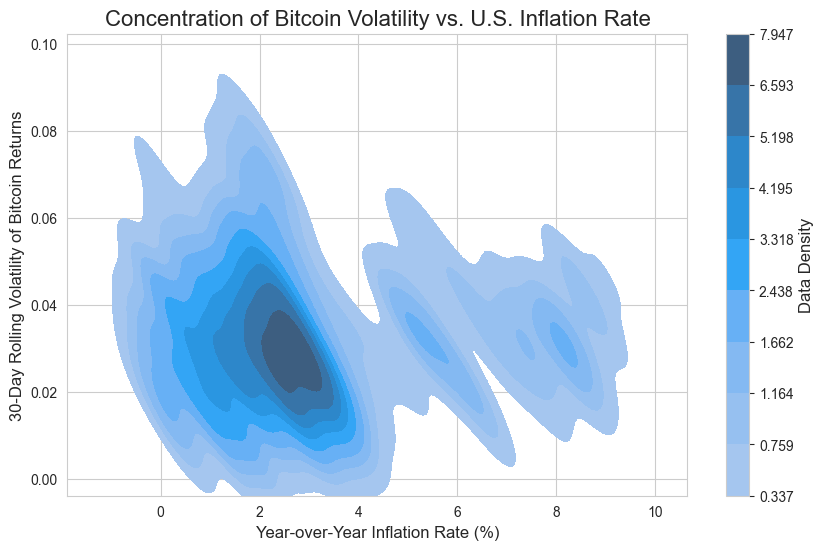

In [7]:
# --- Import Libraries ---
import seaborn as sns
import matplotlib.pyplot as plt

# --- Create the 2D Density Plot ---
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Use kdeplot and store the axes object in the 'ax' variable
ax = sns.kdeplot(data=final_df, x='Inflation_Rate', y='BTC_Volatility',
                 fill=True, cbar=True)


# --- Add Label to Color Bar ---
# Access the color bar (which is the last axes object on the figure) and set its label
ax.figure.axes[-1].set_ylabel('Data Density', fontsize=12)


# --- Add Titles and Labels ---
plt.title('Concentration of Bitcoin Volatility vs. U.S. Inflation Rate', fontsize=16)
plt.xlabel('Year-over-Year Inflation Rate (%)', fontsize=12)
plt.ylabel('30-Day Rolling Volatility of Bitcoin Returns', fontsize=12)


# --- Display the Plot ---
plt.show()